In [2]:
!pip install Keras-Preprocessing
!pip install tensorflow
!pip install efficientnet
!pip install matplotlib seaborn
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


In [1]:
#need to get the data first
#data at https://drive.google.com/drive/folders/11d-cnnm0A6_t4bHq7dc4FChSMx8r0qBM?usp=sharing use the link to copy files into drive to access
from google.colab import drive
drive.mount('/content/drive')

#place the nycu2023mlfinalproject dataset folder at "/content/drive/MyDrive/nycu2023mlfinalproject"

MessageError: Error: credential propagation was unsuccessful

In [4]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# System libraries
from pathlib import Path
import os.path
import random
import os
import csv

In [80]:
# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from keras.preprocessing import image
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [6]:
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [7]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-01-05 02:45:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-05 02:45:46 (88.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [8]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [12]:
data = "/content/drive/MyDrive/nycu2023mlfinalproject/data"
os.chdir(data)

data_directory = os.getcwd()
print(data_directory)
walk_through_dir(data_directory);

/content/drive/MyDrive/nycu2023mlfinalproject/data
There are 2 directories and 1 images in '/content/drive/MyDrive/nycu2023mlfinalproject/data'.
There are 0 directories and 2000 images in '/content/drive/MyDrive/nycu2023mlfinalproject/data/test'.
There are 200 directories and 0 images in '/content/drive/MyDrive/nycu2023mlfinalproject/data/train'.
There are 0 directories and 50 images in '/content/drive/MyDrive/nycu2023mlfinalproject/data/train/195.Carolina_Wren'.
There are 0 directories and 50 images in '/content/drive/MyDrive/nycu2023mlfinalproject/data/train/200.Common_Yellowthroat'.
There are 0 directories and 50 images in '/content/drive/MyDrive/nycu2023mlfinalproject/data/train/194.Cactus_Wren'.
There are 0 directories and 49 images in '/content/drive/MyDrive/nycu2023mlfinalproject/data/train/196.House_Wren'.
There are 0 directories and 50 images in '/content/drive/MyDrive/nycu2023mlfinalproject/data/train/192.Downy_Woodpecker'.
There are 0 directories and 50 images in '/content/d

In [13]:
# Walk through each directory
traindataset = "./train"
testdataset = "./test"
walk_through_dir(traindataset);
walk_through_dir(testdataset);


There are 200 directories and 0 images in './train'.
There are 0 directories and 50 images in './train/195.Carolina_Wren'.
There are 0 directories and 50 images in './train/200.Common_Yellowthroat'.
There are 0 directories and 50 images in './train/194.Cactus_Wren'.
There are 0 directories and 49 images in './train/196.House_Wren'.
There are 0 directories and 50 images in './train/192.Downy_Woodpecker'.
There are 0 directories and 50 images in './train/199.Winter_Wren'.
There are 0 directories and 50 images in './train/193.Bewick_Wren'.
There are 0 directories and 50 images in './train/197.Marsh_Wren'.
There are 0 directories and 50 images in './train/198.Rock_Wren'.
There are 0 directories and 50 images in './train/191.Red_headed_Woodpecker'.
There are 0 directories and 50 images in './train/182.Yellow_Warbler'.
There are 0 directories and 50 images in './train/183.Northern_Waterthrush'.
There are 0 directories and 40 images in './train/187.American_Three_toed_Woodpecker'.
There are 0

In [15]:
image_dir = Path(traindataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [16]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [19]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
'''
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)
'''
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7830 validated image filenames belonging to 200 classes.
Found 1958 validated image filenames belonging to 200 classes.


In [20]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224, 224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
  layers.experimental.preprocessing.RandomCrop(224, 224)
])

In [21]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = True

16705208/16705208 [==============================] - 1s 0us/step


In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [23]:
x = pretrained_model.layers[-2].output
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

x = GlobalAveragePooling2D()(x)

outputs = Dense(200, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

for layer in pretrained_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(lr=0.00015),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    epochs=70,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "bird_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)


Saving TensorBoard log files to: training_logs/bird_classification/20240105-025623
Epoch 1/70
245/245 [==============================] - ETA: 0s - loss: 5.7179 - accuracy: 0.2327 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 3455s 14s/step - loss: 5.7179 - accuracy: 0.2327 - val_loss: 3.3497 - val_accuracy: 0.4699 - lr: 0.0010
Epoch 2/70
245/245 [==============================] - 41s 167ms/step - loss: 3.1099 - accuracy: 0.4622 - val_loss: 2.7290 - val_accuracy: 0.5419 - lr: 0.0010
Epoch 3/70
245/245 [==============================] - 38s 154ms/step - loss: 2.7510 - accuracy: 0.5238 - val_loss: 2.5465 - val_accuracy: 0.5587 - lr: 0.0010
Epoch 4/70
245/245 [==============================] - 38s 155ms/step - loss: 2.5629 - accuracy: 0.5566 - val_loss: 2.4629 - val_accuracy: 0.5873 - lr: 0.0010
Epoch 5/70
245/245 [==============================] - 36s 147ms/step - loss: 2.4526 - accuracy: 0.5838 - val_loss: 2.3409 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 6/70
245/245 [==============================] - 38s 155ms/step - loss: 2.3518 - accuracy: 0.5978 - val_loss: 2.2608 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 7/70
245/245 [==============================] - 39s 160ms

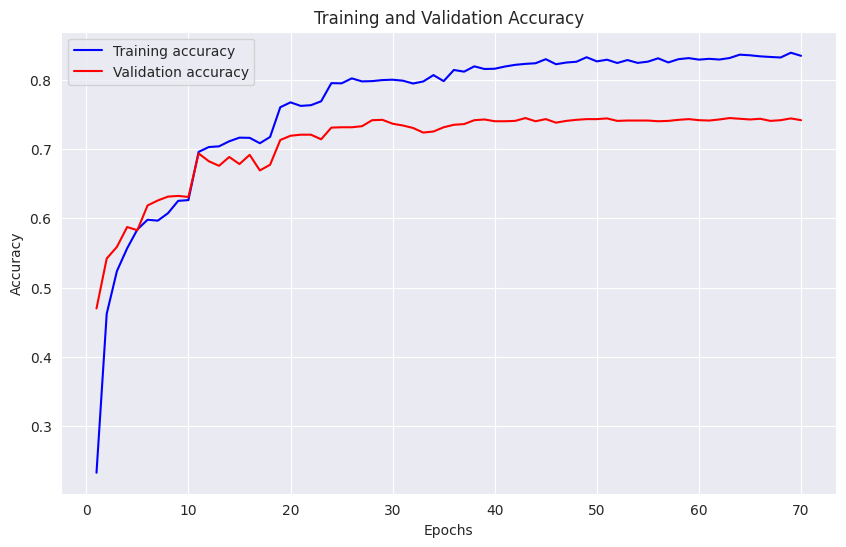

In [77]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 获取epoch的数量
epochs = range(1, len(train_acc) + 1)

# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

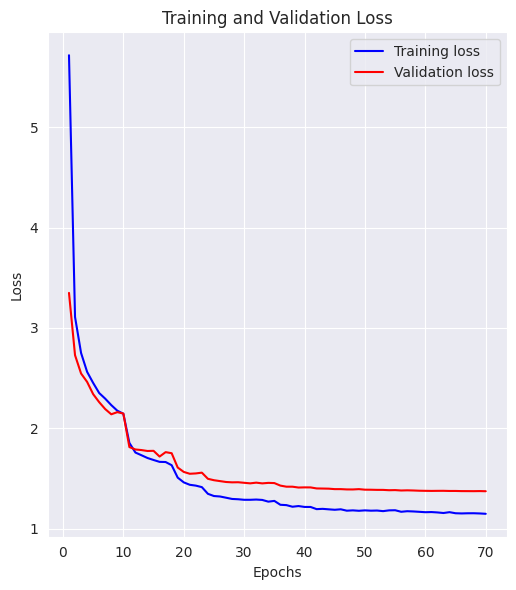

In [79]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 获取epoch的数量
epochs = range(1, len(train_loss) + 1)

# 绘制学习曲线
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [38]:
model.save('efficient_B0.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
# Load the model
loaded_model = load_model('efficient_B0.h5')

In [74]:
all_layers = loaded_model.layers

with open('109611092_weights.txt', 'w') as f:
    for layer in all_layers:
        f.write(f"Layer Name: {layer.name}\n")
        weights = layer.get_weights()
        for w in weights:
            if w.ndim == 0:
                w_processed = np.array([w])
            else:
                w_processed = w.flatten()
            np.savetxt(f, w_processed, delimiter=',', fmt='%.8f')
        f.write("\n")

In [44]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

test_image_paths = list(Path(testdataset).glob("*"))
test_image_paths = [str(path) for path in test_image_paths]

test_df = pd.DataFrame({
    'Filepath': test_image_paths,
})

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 2000 validated image filenames.


In [45]:
train_folder_path = "./train"
folder_names = os.listdir(train_folder_path)
label_map = {folder_name: i for i, folder_name in enumerate(folder_names)}

test_df['Class'] = test_df['Filepath'].apply(lambda x: os.path.basename(os.path.dirname(x)))
test_df['Label'] = test_df['Class'].map(label_map)


In [82]:
folder_names = sorted(os.listdir(train_folder_path))
label_map = {class_name: f"{i:03d}.{class_name}" for i, class_name in enumerate(folder_names)}

# 假设 test_df 已经包含 'Filepath' 列
test_df['Class'] = test_df['Filepath'].apply(lambda x: os.path.basename(os.path.dirname(x)))
test_df['Label'] = test_df['Class'].map(label_map)

# 进行预测
predictions = loaded_model.predict(test_images)

test_df['id'] = test_df['Filepath'].apply(lambda x: os.path.basename(x).replace('.jpg', ''))

predictions_list = []
for i, filename in enumerate(test_df['id']):
    predicted_class_index = np.argmax(predictions[i])
    predicted_class = None
    for class_name, class_label in label_map.items():
        if int(class_label[:3]) == predicted_class_index:
            predicted_class = class_label[4:]
            break
    predictions_list.append([filename, predicted_class])

result_df = pd.DataFrame(predictions_list, columns=['id', 'label'])

result_df = result_df.sort_values(by='label')

result_df.to_csv('predictions_sorted.csv', index=False)


63/63 [==============================] - 10s 164ms/step


In [75]:
!nvidia-smi

Fri Jan  5 05:33:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              29W /  70W |   2173MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [76]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
